In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os

Using TensorFlow backend.


In [2]:
data = pd.read_csv('C:\\Users\\shkatta\\Desktop\\AI\\csv files\\fer201.csv')
#check data shape
data.shape

(5093, 3)

In [3]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,729
1,Sad,834
2,Digust,74
3,Surprise,538
4,Fear,738
5,Neutral,883
6,Happy,1297


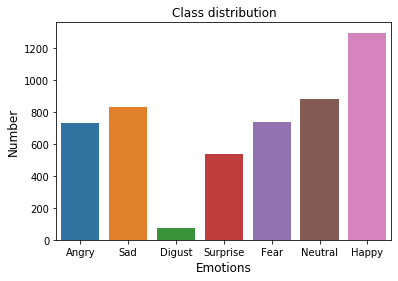

In [5]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

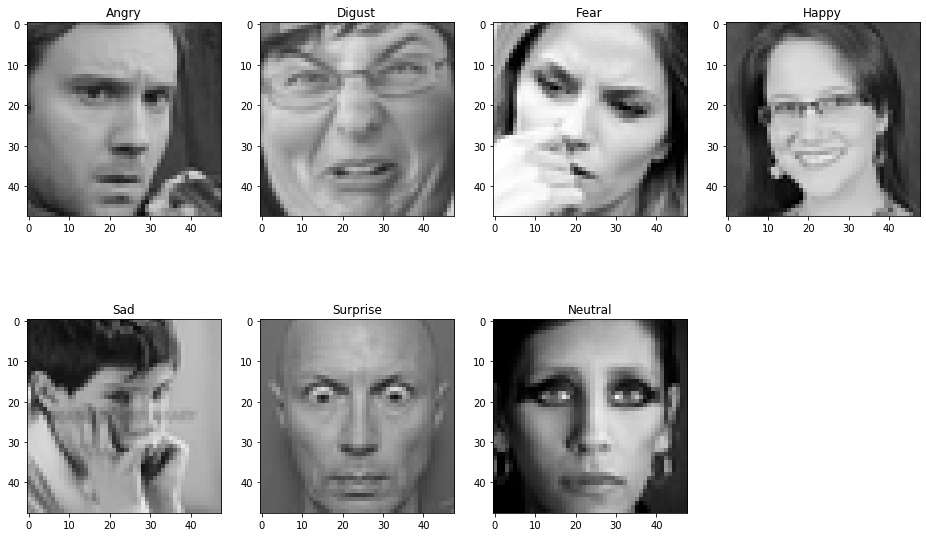

In [6]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show() 

In [7]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))


train shape: (4998, 3), 
validation shape: (95, 3), 
test shape: (0, 3)


TypeError: no numeric data to plot

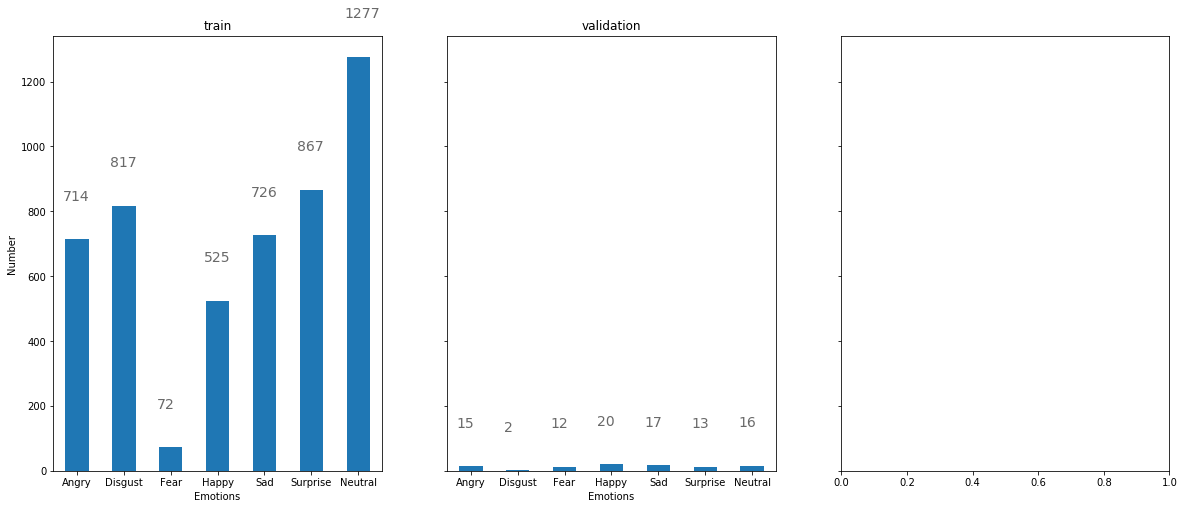

In [8]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [8]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [9]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (4998, 48, 48, 1)
val _X shape: {},  val _Y shape: (95, 48, 48, 1)
test _X shape: {},  test _Y shape: (0, 48, 48, 1)


In [10]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 256)      

In [11]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=True,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)




C:\Users\shkatta\New folder\lib\site-packages\keras_preprocessing\image\image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [12]:
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=10,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/10


C:\Users\shkatta\New folder\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\shkatta\New folder\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 739s - loss: 1.8922 - accuracy: 0.2395 - val_loss: 1.8214 - val_accuracy: 0.2105
Epoch 2/10
 - 709s - loss: 1.7545 - accuracy: 0.2887 - val_loss: 1.8895 - val_accuracy: 0.2105
Epoch 3/10
 - 699s - loss: 1.7170 - accuracy: 0.3095 - val_loss: 1.9894 - val_accuracy: 0.1684
Epoch 4/10
 - 677s - loss: 1.6685 - accuracy: 0.3467 - val_loss: 2.1331 - val_accuracy: 0.2316
Epoch 5/10
 - 678s - loss: 1.6060 - accuracy: 0.3735 - val_loss: 1.8220 - val_accuracy: 0.2632
Epoch 6/10
 - 694s - loss: 1.5603 - accuracy: 0.3938 - val_loss: 1.9171 - val_accuracy: 0.2737
Epoch 7/10
 - 694s - loss: 1.5065 - accuracy: 0.4012 - val_loss: 1.7515 - val_accuracy: 0.3263
Epoch 8/10
 - 719s - loss: 1.4521 - accuracy: 0.4312 - val_loss: 1.5486 - val_accuracy: 0.3789
Epoch 9/10
 - 727s - loss: 1.4348 - accuracy: 0.4432 - val_loss: 1.5863 - val_accuracy: 0.3474
Epoch 10/10
 - 733s - loss: 1.3711 - accuracy: 0.4696 - val_loss: 1.8474 - val_accuracy: 0.3895


In [13]:
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()


NameError: name 'axes' is not defined

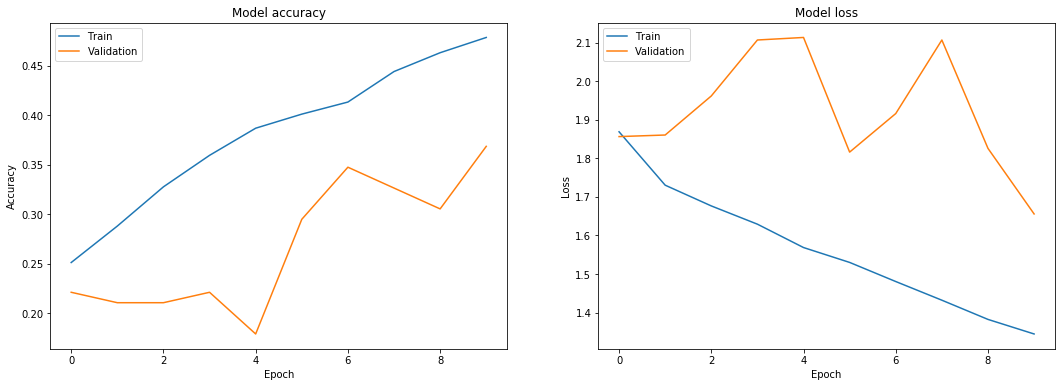

In [17]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
import cv2
face_clsfr=cv2.CascadeClassifier('C:\\Users\\shkatta\\Desktop\\AI\\csv files\\haarcascade_frontalface_default.xml')

source=cv2.VideoCapture('C:\\Users\\shkatta\\Desktop\\opencv-1\\face.mp4')

labels_dict= {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
color_dict={0:(0,0,255),1:(0,255,0),2:(0,255,0),3:(0,255,0),4:(0,255,0),5:(0,255,0),6:(0,255,0)}

In [21]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(img,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(48,48))
        normalized=resized/255.0
        reshaped=normalized.reshape((1,48,48,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [51]:
model.save('C:\\Users\\shkatta\\Desktop\\opencv-1\\best')

In [52]:
reconstructed_model = keras.models.load_model('C:\\Users\\shkatta\\Desktop\\opencv-1\\best')

In [53]:
source1=cv2.imread("C:\\Users\\shkatta\\Desktop\\opencv-1\\smile.jpg")
while(True):

    #img=cv2.imread(source1)
    gray=cv2.cvtColor(source1,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(48,48))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,48,48,1))
        result=reconstructed_model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(source1,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(source1,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(source1, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',source1)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()